# One dimensional elementary cellular automata - with a twist!

While the resulting image may appear to be 2 dimensional, this system is in fact one dimensional, where each time step is stacked underneath the last.

Let's start with cell states. Because the state of a cell is binary (on or off), every cell neighborhood (3 adjacent cells) can look like one of 8 = 2<sup>3</sup> possible configugrations.

<img src='./img/bits.png' style="display: block; margin-left: auto; margin-right: auto;"> </img>

Now all we need is a *rule*. A rule is any integer up to 256 converted to binary, thus looking like a byte. 

Rule '30' for instance, would look like 
`00011110`

Now, remember the set of all permutations for 3-bit sequences (neighborhoods) from earlier? Conserving their order (which can be stored in a tuple `('111','110','101','100','011','010','001','000')`), each of these is now mapped to an individual bit in the binary rule, the latter determining how the center cell in each neighborhood should evolve in time. Using rule 30 (`00011110`) for instance, if one neighborhood of one time step (remember, each time step is a long strip of bits) looks like the fourth neighborhood of our tuple - `100` -, then this should map to the fourth bit of the rule - which is 1. Because the rules only affect the center cell of the neighborhood, the same neighborhood in the next time step will look like `010`, or a shift to the right.

Thus, after one time step, the system's evolution (*only considering* the `100` neighborhood) will look as follows: 

<img src='./img/evol.png' style="display: block; margin-left: auto; margin-right: auto;"> </img>

Given the the amount of rules you can select, and the different possible combinations of adjacent neighborhoods, you might conjecture how complex this system really is. If we let this system run for multiple time steps, some pretty rad patterns begin to develop. Using rule 30, and a width of 100 pixels, let's see what happens after 100 steps if we start with just one pixel in the center:

<img src='./img/rule30.png' style="display: block; margin-left: auto; margin-right: auto;"> </img>

Pretty rad indeed. If you zoom in at the second step you will notice that it's different than what I illustrated above. This is because I was only considering the `100` neighborhood to break things down. But depending on where you are looking – as you "slide" across the state – that single cell can either be interpreted as `100`, `010`, or `001`. In the rule, these all map to `1`, thus the second step in rule 30 is really `111`.  (Fun fact: rule 30's output is strikingly similar to the [_Conus Textile_ seashell pattern](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Textile_cone.JPG/440px-Textile_cone.JPG), and more importantly exhibits [*chaos*](https://www.wikiwand.com/en/Chaos_theory).) 

Each rule has a unique output, [some more unique than others](https://mathworld.wolfram.com/ElementaryCellularAutomaton.html). The incredible emergence of patterns has led some people to research the mechanisms behind this pattern creation in depth, notably the "inventor" of the cellular automata himself, [Stephen Wolfram](https://www.youtube.com/watch?v=VguG_y05Xe8).

For my design, I decided to take one step further and see what would happen if we _combined_ rules. (Given that a "combination" of rules is open to interpretation, there are probably several approaches to this.) I thought that randomly switching between given rules at each timestep might yield some interesting results. After playing around with several combinations, my favorite was a mixture of 169 and 225.

# Code

I implemented a CellularAutomaton class, as I thought this might consolidate functionality by sharing parameters between methods.

Please play around with the code (visit the Colab link above or clone this [repository](https://github.com/bfbarry/DesignCell)) by changing the width, length of time, and rule(s). Optionally, you can also pass in an initial condition in the `CellularAutomaton.run` method, instead of the default center cell.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

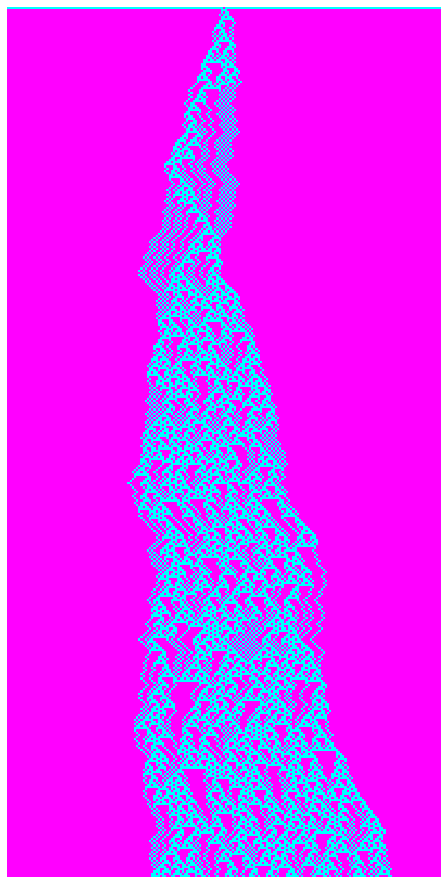

In [4]:
class CellularAutomaton:
    def __init__(self, rule = None):
        """If rule is sequence, then randomly changes between generated rulesets in self.run() """
        #creating rule table
        if type(rule) == int:
            self.make_ruleset(rule)
        self.rule = rule
        
    def make_ruleset(self, _rule):
        """Generates a hash table of form {current_neighborhood_configuration : state_in_next_iteration, ... }"""
        _rule = bin(_rule)[2:] 
        while len(_rule) is not 8: #to ensure proper byte length of rule
            _rule = '0' + _rule
        
        neighbors = ('111','110','101','100','011','010','001','000')
        ruleset = dict.fromkeys(neighbors)
        for neighbor, bit in zip(neighbors, _rule):
            ruleset[neighbor] = bit

        self.ruleset = ruleset
        
    def update(self, current_state):
        """given current_state (a 1d line of pixels) returns next state in time"""
        new_state = [0 for i in range(len(current_state))]
        for i in range(1,len(current_state) - 2): #avoiding edges
            l,c,r = current_state[i - 1], current_state[i], current_state[i + 1]
            new_state[i] = int(self.ruleset[f'{l}{c}{r}'])
        return new_state

    def run(self, lifetime, width, t0 = None, xlim=None):
        """
        Simulates the cellular automaton over time
        lifetime: number of steps
        width: width of state
        t0: initial condition (optional)
        """
        grid = [] #really a bunch of 1d state arrays
        if t0 is None:
            t0 = [0 for i in range(width)]
            t0[int(width/2)] = 1

        grid.append(t0)
        current_state = t0
        for t in range(lifetime):
            if type(self.rule) != int: # if given multiple rules to switch between
                self.make_ruleset(np.random.choice(self.rule))
            current_state = self.update(current_state)
            grid.append(current_state)
            
        plt.imshow(grid,cmap='cool')
        if xlim:
            plt.xlim(xlim)
        plt.axis('off')
        save = False
        if save:
            plt.savefig('img/CA.png', dpi=500, bbox_inches='tight')
        plt.show()

x = CellularAutomaton(rule = (169,225))
plt.figure(figsize=[16,16])
x.run(lifetime=400, width=600, xlim=(200,400))

## Acknowledgements

Shout out to Daniel Shiffman for his simple explanation of cellular automata in his online book, [_The Nature of Code_](https://natureofcode.com/book/chapter-7-cellular-automata/).